In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(ggplot2)        
        library(scales)
        library(patchwork) 
        library(purrr)
        library(dplyr)
        library(GGally)
        library(ISLR)
    })
})

In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")


# Data Science Project: Project Final Report


## Introduction: 
For this project, we are analyzing data collected by researchers in Computer Science at UBC. They have set up a MineCraft server that allows them to record consenting players’ behaviour and characteristics for study. In particular, we want to answer the question: **What players' `Age`, `gender`, and `played_hours` can best predict whether they would `subscribe` to a gaming newsletter, and how does it differ from players `experience`?** In this project, we will focus on the `players.csv` dataset, as it is of most use to us to answer our question. The `players.csv` set contains 196 observations and 7 variables. This data is already in its tidy form because every column is a single variable, every row is a single observation, and every cell is a single value.  We can see that there are three types of variables here: character, logical, and double. 

**Character Variables:**

`hashedEmail` (email of player that has been converted into a unique string of characters, for privacy)

`name` (first name of player)

`gender` (gender of player)

`experience` (skill level of player)

**Double Variables:**

`played_hours` (number of hours spent on the game by each player)

`Age` (age in years of each player)

**Logical variable:**

`subscribe` (whether or not the player is subscribed to the game newsletter) 

For our question, we want to know if a player's age, gender, and amount of played hours can determine if they will subscribe to the game newsletter or not. We chose these three predictor variables because they are all characteristics of each individual player that can allow us to group them and determine which type of player is most likely to subscribe. Additionally, we want to determine if any difference in experience across players will be a factor in whether or not a player is subscribed.

A potential issue with this data under the `played_hours` variable, we can see that many players have 0 hours played. This could cause weird results when we begin to wrangle. Furthermore, some values under the `gender` variable contain very little sample sizes, making it hard to scale these categories. 

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
#TODO will need additional wranggling due to poor or few varied sample categories
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                played = factor(as.logical(played_hours)), # TODO may not use 
            ) |>
             mutate(gender = fct_recode(gender, # Aggregate some of the gender to balance out count and avoid missclassification due to underepresented categories
                                    "Non-binary/Other" = "Agender",
                                    "Non-binary/Other" = "Non-binary",
                                     "Non-binary/Other" = "Two-Spirited",
                                    "Non-binary/Other" = "Other"
                                      ))
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `gender = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: Other”


### Training and Analysis:

In [4]:
# head(player_df) # TODO DELETE tmp  for set up 

In [5]:
# SPLIT/SCALE DATA
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.70, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

In [6]:
#TODO DELETE 
## tr_sub_counts <- ggplot(player_train, aes(x = subscribe, fill = subscribe)) +
#                 geom_bar() + 
#                 ylim(c(0,100)) + 
#                 guides(fill = "none") +
#                 labs(x = "Subscribe status", y = "Count of players") + 
#                 ggtitle("Training set")
                
# tst_sub_counts <- tr_sub_counts %+% player_test +
#                 ggtitle("Testing Set")


                

# tr_sub_counts + tst_sub_counts

player_split

<Training/Testing/Total>
<135/59/194>

**Data Split:**

Due to a small, fairly imbalanced data set of 194 data points, we will use an 'initial_split' of 70% (135) training and 30% (59) testing sets to try to balance the split across all our predictors. Our goal is to train a model to predict the outcome of subscription, thus our strata will be set to `subscribe` variable. 


In [7]:
# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_predictors())




**Recipes:**

We've put together 7 recipes to explore all the different combinations of predictors for `subscribe`. We will train using our player training dataset. Our recipe must normalize variables to remove discrepancies in the evaluation weight. We will use step_dummy <sup>[1](#ref1)</sup> to convert our factors/categorical variables (e.g., experience, gender) into dummy numerical variables, then use step_zv<sup>[2](#ref2)</sup>  to remove any single-value data sets that would interfere with our modelling, followed by normalize to avoid scaling issues due to different units of measurement.

> **Combinations of our recipes:**
>
> 1. Age + gender + played_hours
> 2. Age + played_hours
> 3. Age + gender
> 4. Gender + played_hours
> 5. Age
> 6. gender
> 7. played_hours


In [8]:
# Spec set up
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

In [9]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
set.seed(1234) # Don't change
kfolds <- vfold_cv(player_train, v = 5, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))


**Tuning setup for K:**

Put together our k-NN tune function and set up our k values from 1 to 10. We choose to go up to 10, as anything beyond that would increase our risk of underfitting given our small, skewed data set. We will use 5-fold cross-validation to determine our best-performing model. We keep it low as our sample size is small and heavily skewed. This way, we can reduce the missing categories in our folds.

In [10]:

# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_tune),
    cross = TRUE
)

# Tune workflow
# set.seed(22)

knn_tuned_set <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_vals,
    seed = 22
)


**Workflow for Tunning k:**

We turned our recipes and knn_tune values into a workflow_set and used workflow_map to apply our training across all recipe-k combinations.<sup>[3](#ref3)</sup> We are using tune_grid to resample our kfolds for our cross validation training.

In [11]:

options(repr.plot.width = 15, repr.plot.height = 5)
# Get metrics all in one
all_metrics_collected <- workflow_map(
    knn_tuned_set,
    metrics = metric_set(accuracy, recall, precision)
) 

all_metrics_collected_res <- collect_metrics(all_metrics_collected)

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 7 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x2



→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 7 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x1





In [12]:
# res_All_met_tuned

In [13]:
# all_metrics_collected_res
#TODO TMP trying to regain neighbours
res_All_met_tuned <- all_metrics_collected |>
            rowwise() |>
            mutate(metrics = list(collect_metrics(result)),
                  wflow_id = fct_recode(wflow_id,
                      "Age, gender and played hours" = "AGH_nearest_neighbor",
                      "Gender and played hours" = "GH_nearest_neighbor",
                      "Gender" = "G_nearest_neighbor",
                      "Age and gender" = "AG_nearest_neighbor",
                      "Age and played hours" = "AH_nearest_neighbor",
                      "Age" = "A_nearest_neighbor",
                      "Played hours" = "H_nearest_neighbor"
                  )) |>
            unnest(metrics) |>
            select(wflow_id, .metric, mean, neighbors, std_err) |>
            arrange(desc(mean))
# ADD RANKING
ranked_met <- res_All_met_tuned |>
            mutate(rank = seq(1, nrow(res_All_met_tuned), 1))
# ranked_met
# Visualize result
options(repr.plot.width = 8, repr.plot.height = 5)

plot_met_tmp <- ggplot(ranked_met, aes(x = rank, y = mean, color = wflow_id)) +
                geom_point(size = 2, alpha = 0.8) +
                ylim(c(0,1)) + 
                labs(x = "Ranke by metric mean", y = "Metric percentage", color = "Predictor Combinations") 



Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `wflow_id = fct_recode(...)`.
ℹ In row 1.
Caused by warning:
! Unknown levels in `f`: GH_nearest_neighbor, G_nearest_neighbor, AG_nearest_neighbor, AH_nearest_neighbor, A_nearest_neighbor, H_nearest_neighbor
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


In [14]:
# METRICS set up Graphs
# Accuracy
acc_met <- res_All_met_tuned |>
            filter(.metric ==  "accuracy")
acc_met_rank <- mutate(acc_met, rank = seq(1, nrow(acc_met), 1))  |>
                slice(1:30)
acc_met_plot <- plot_met_tmp %+% acc_met_rank +
                guides(color = "none") + 
                labs(caption = "Graph 3.1: Accuracy performance ranke for k-nn model n(k)") +
                ggtitle("Top 30 k-nn Ranked by Accuracy Mean n(k) 3.1") 

                


# Precision
prec_met <- res_All_met_tuned |>
            filter(.metric ==  "precision")
prec_met_rank <- mutate(prec_met, rank = seq(1, nrow(prec_met), 1)) |>
                slice(1:30)
prec_met_plot <- plot_met_tmp %+% prec_met_rank +
                guides(color = "none") + 
                labs(caption = "Graph 3.2: Precision performance ranke for k-nn model n(k)") +
                ggtitle("Top 30 k-nn Ranked by Precision Mean n(k) 3.2") 
                



# Recall
rec_met <- res_All_met_tuned |>
            filter(.metric ==  "recall")
rec_met_rank <- mutate(rec_met, rank = seq(1, nrow(rec_met), 1))  |>
                slice(1:30)
rec_met_plot <- plot_met_tmp %+% rec_met_rank +
                labs(caption = "Graph 3.3: Recall performance ranke for k-nn model n(k)") +
                ggtitle("Top 30 k-nn Ranked by Recall Mean n(k) 3.3")


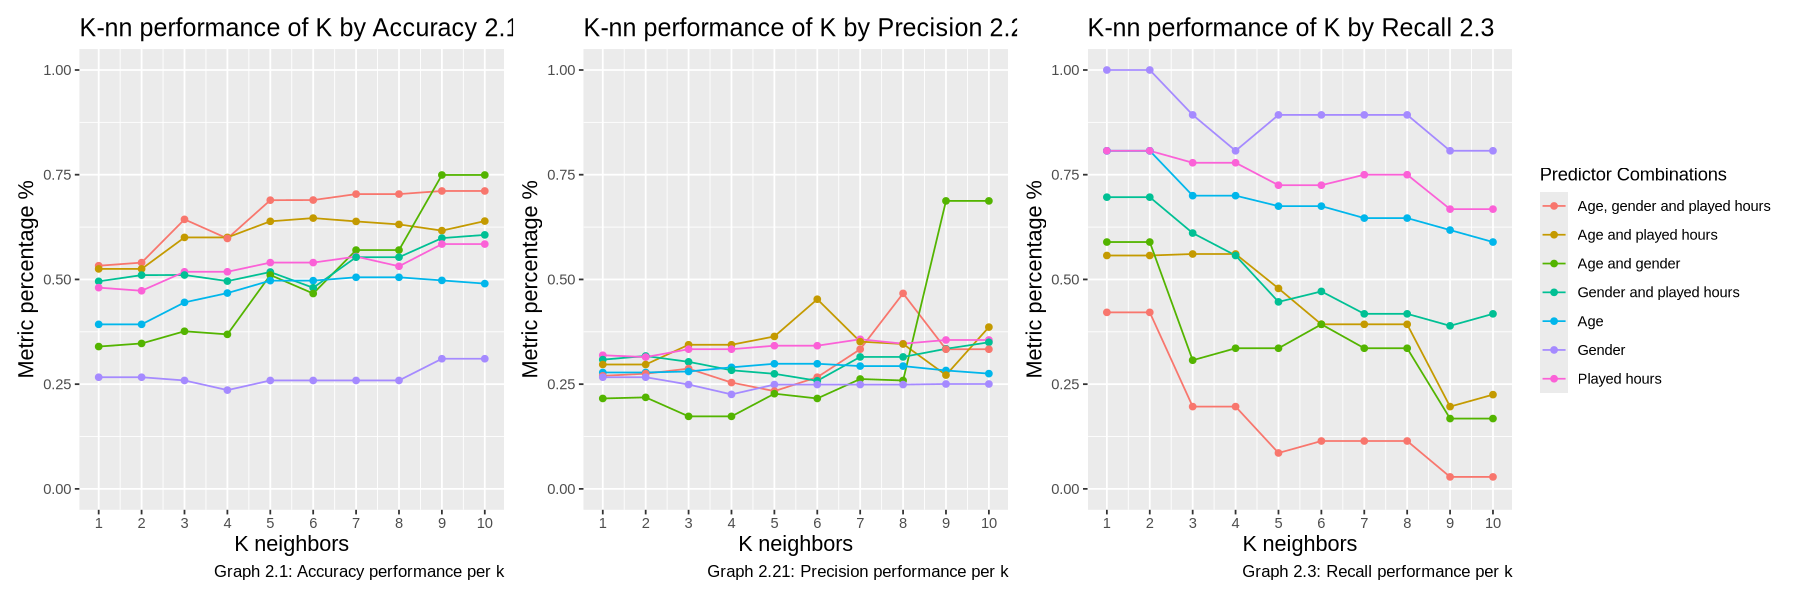

In [15]:
# LINE Graph showing k performance for each recipe
options(repr.plot.width = 15, repr.plot.height = 5)

overlapped_line_tmp <- ggplot(acc_met, aes(x = neighbors, y = mean, color = wflow_id)) +
                        geom_line() +
                        geom_point() + 
                        ylim(c(0, 1)) + 
                        scale_x_continuous(breaks = seq(0,nrow(acc_met),1)) +
                        labs(
                            x = "K neighbors", 
                            y = "Metric percentage %",  
                            color = "Predictor Combinations",
                        )  +
                        theme(
                            plot.title = element_text(size = 15), 
                            axis.title.x = element_text(size = 13),
                            axis.title.y = element_text(size = 13),
                            plot.caption = element_text(size = 10)
                            ) + 
                        ggtitle("K-nn performance of K by Accuracy 2.1")

# LINE Graph showing k performance for each recipe, using Accuracy
overlapped_line_acc <- overlapped_line_tmp %+% acc_met + 
                        guides(color = "none") +
                        labs(caption = "Graph 2.1: Accuracy performance per k") +
                        ggtitle("K-nn performance of K by Accuracy 2.1")

# LINE Graph showing k performance for each recipe, using precision
overlapped_line_prec <- overlapped_line_tmp %+% prec_met +
                        labs(caption = "Graph 2.21: Precision performance per k") + 
                        guides(color = "none") +
                        ggtitle("K-nn performance of K by Precision 2.2")

# LINE Graph showing k performance for each recipe, using recall
overlapped_line_rec <- overlapped_line_tmp %+% rec_met +
                        labs(caption = "Graph 2.3: Recall performance per k") +
                        ggtitle("K-nn performance of K by Recall 2.3")

overlapped_line_acc +
overlapped_line_prec +
overlapped_line_rec 


**K CROSS-VALIDATION METRICS**

After training our models and collecting metrics, we can visualize the performance of each k for each predictor combination of our k-nearest neighbour classification model. Initially, we planned to focus on the precision metric (Graph 2.2) to reduce false positives, as we deemed having non-subscribe show up as subscribe to be undesirable, but including accuracy (Graph 2.1) and recall (Graph 2.3) alongside it gave us an interesting perspective on our performance. Our precision metric (Graph 2.2) wavers a bit and remains relatively flat, with fairly poor performance, due to our small and skewed data set. The exception is that the student's performance jumps when k = 9 for the "Gender and played hours" combination, which is a sign of underfitting and indicates that the model is covering all data in the training fold. When we look at recall, which penalizes false negatives, we see, in most cases, a downward trend as k increases, reflecting the skew in our data set, which has more subscribers than unsubscribers. In the end, we chose k = 5 based on accuracy (Graph 2.1) with the "Age, gender and played hours" predictors, as it is the most accurate before it starts to smooth out.

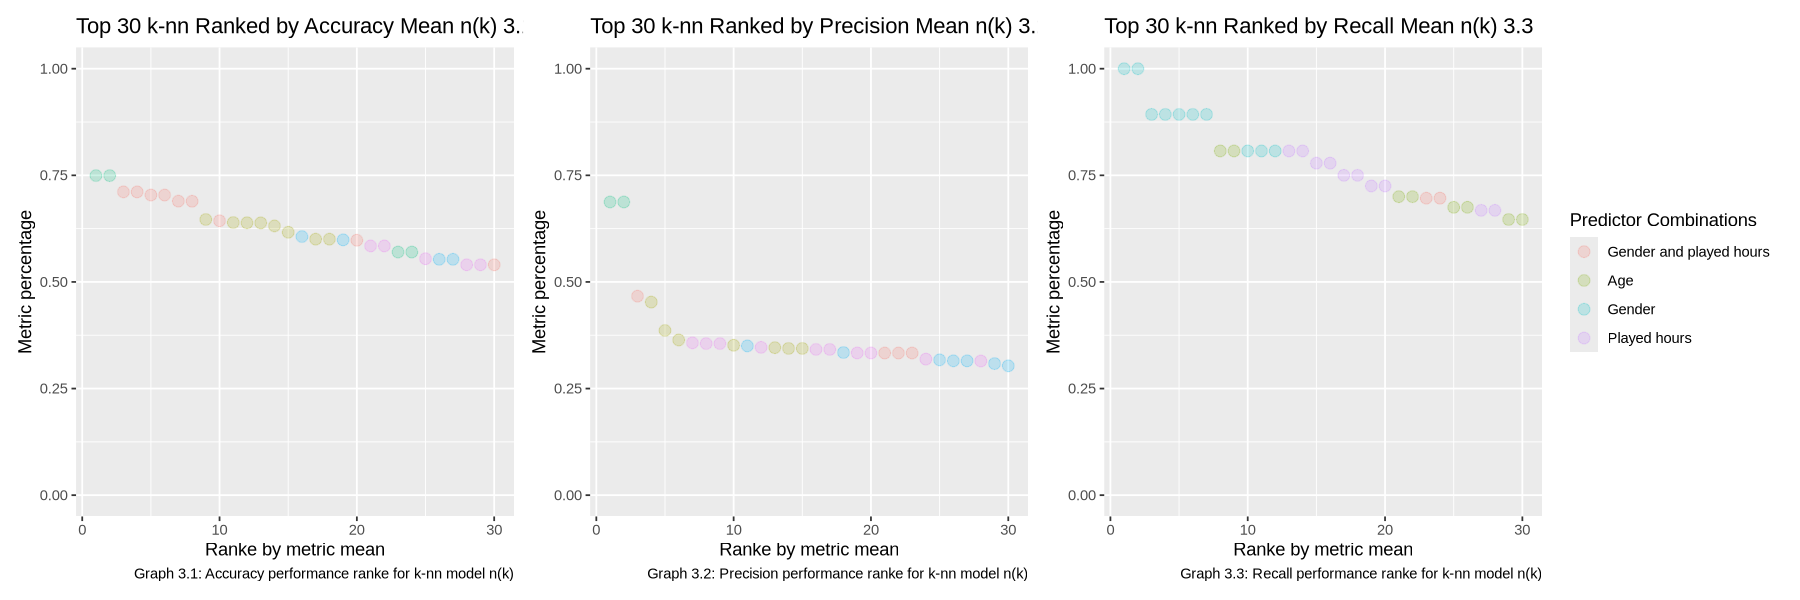

In [16]:
# All results side by side
options(repr.plot.width = 15, repr.plot.height = 5)
#TODO fabio add std_err line but also combine color and shape legend
# side_by_side_met
acc_met_plot + prec_met_plot + rec_met_plot

**Further visualization:**

To further reinforce our decision, we sorted and ranked our predictor models by metric performance for all k tuning to visualize each combination's performance relative to the others. (Graph: 3.1, 3.2, 3.3)

In [17]:
# SELECT FINAL MODEL AND TRAIN 
set.seed(22)
# Model Age + played_hours with k = 5 recipe(rc_AGH)
final_md_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

final_md_fit <- workflow() |>
            add_recipe(rc_AGH) |>
            add_model(final_md_spec) |>
            fit(player_train)
# final_md_fit


########
final_md_pred <- predict(final_md_fit, player_test) |>
                bind_cols(player_test)
# final_md_pred
final_md_met <- final_md_pred |>
                metrics(truth = subscribe, estimate = .pred_class)
final_md_met
final_md_mat <- conf_mat(final_md_pred, truth = subscribe, estimate = .pred_class)
final_md_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136
kap,binary,0.2224053


          Truth
Prediction FALSE TRUE
     FALSE     5    5
     TRUE     11   38

**Final fitting of model:**

Now we have fitted our model. Using our specification of k-nearest neighbour classification model with k = 5 and our recipe combination of predictors `Age`, `gender` and `

### Player Type Exploration: "TODO may need renaming"

## Discussion:

### Reference 

##### Data Science programming techniques and approaches:

> 1. <a name="ref1"></a> TidyX. “TidyX Episode 84 | Tidymodels - Workflow Sets and Model Selection.” YouTube, 21 Nov. 2021, www.youtube.com/watch?v=YZqbOATpjM4. Accessed 1 Dec. 2025.
> 2. <a name="ref2"></a>“Zero Variance Filter — Step_zv.” Tidymodels.org, 2025, recipes.tidymodels.org/reference/step_zv.html. Accessed 1 Dec. 2025.
> 3. <a name="ref3"></a>TidyX. “TidyX Episode 84 | Tidymodels - Workflow Sets and Model Selection.” YouTube, 21 Nov. 2021, www.youtube.com/watch?v=YZqbOATpjM4. Accessed 2 Dec. 2025.

‌

‌

- **workflowset:** https://workflowsets.tidymodels.org/
- **Clustering prediction:** https://www.youtube.com/watch?v=z57i2GVcdww
- **Simplifying multi-model set up + testing:** https://www.youtube.com/watch?v=YZqbOATpjM4
- **Tuning and comparing models using Workflowse:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html
- **Useful example of report/tutorial for tidy models:** https://optimumsportsperformance.com/blog/k-nearest-neighbor-tidymodels-tutorial/
- **Additional breakdown on workflow_set usage:** https://www.youtube.com/watch?v=R95lWUDtL5A
- **Workflow_set documentation on results:** https://workflowsets.tidymodels.org/reference/collect_metrics.workflow_set
- **Workflow_set tunning and comparing documentation:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models
- **Plot ggpair examples breakdown for reference:** https://r-charts.com/correlation/ggpairs/
- **margin of error plot template models:** https://www.sthda.com/english/wiki/ggplot2-error-bars-quick-start-guide-r-software-and-data-visualization

In [19]:
#TODO tmp info grounds

?guides

guides {ggplot2},R Documentation
...,"List of scale name-guide pairs. The guide can either be a string (i.e. ""colorbar"" or ""legend""), or a call to a guide function (i.e. guide_colourbar() or guide_legend()) specifying additional arguments."
